<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/FMC_Code14_Curve_Fitting_with_2023_whole_year_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to fit all four models (linear, logarithmic, exponential, power-law) to both rank and inverse rank curves for each index, evaluate R², RMSE, AIC, and BIC, and output a summary Excel table of all fit parameters and statistics. It also saves the best-fit plot for each case.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 9.6 MB/s eta 0:00:00


In [3]:
#@title setup and imports
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os

# Candidate functions
def linear(x, a, b):
    return a * x + b

def logarithmic(x, a, b):
    return a * np.log(x) + b

def exponential(x, a, b):
    return a * np.exp(b * x)

def power_law(x, a, b):
    return a * (x ** b)

In [4]:
# Setting to use a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# Setting to Use a High-RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 185.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
#@title Goodness-of-fit Metrics
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

def bic(n, rss, k):
    return n * np.log(rss / n) + k * np.log(n)

In [7]:
#@title Fitting & Comparison Function
def fit_and_compare(x, y):
    models = {
        'Linear':   (linear,      [1, 0]),
        'Log':      (logarithmic, [1, 0]),
        'Exp':      (exponential, [1, 0.01]),
        'Power':    (power_law,   [1, -1])
    }
    results = []
    for name, (func, p0) in models.items():
        try:
            # For log and power, x must be > 0
            if name in ['Log', 'Power']:
                mask = x > 0
                x_fit, y_fit = x[mask], y[mask]
            else:
                x_fit, y_fit = x, y
            popt, pcov = curve_fit(func, x_fit, y_fit, p0=p0, maxfev=10000)
            y_pred = func(x_fit, *popt)
            n = len(y_fit)
            k = len(popt)
            rss = np.sum((y_fit - y_pred) ** 2)
            r2 = r_squared(y_fit, y_pred)
            rmse_val = rmse(y_fit, y_pred)
            aic_val = aic(n, rss, k)
            bic_val = bic(n, rss, k)
            param_dict = {f'param_{i+1}': v for i, v in enumerate(popt)}
            results.append({
                'Model': name,
                'R2': r2,
                'RMSE': rmse_val,
                'AIC': aic_val,
                'BIC': bic_val,
                **param_dict,
                'n': n,
                'k': k,
                'rss': rss,
                'func': func,
                'x_fit': x_fit,
                'y_pred': y_pred
            })
        except Exception as e:
            # You might want to log the exception
            pass
    return results

In [18]:
#@title Plotting Function

def plot_best_fit(x, y, fit_results, index_name, rank_type, plot_title=None, save_dir=None):
    best = max(fit_results, key=lambda res: res['R2'])
    plt.figure(figsize=(10,6))
    plt.plot(x, y, 'o', color='black', markersize=1, label='Data') # <-- reduced marker size
    plt.plot(best['x_fit'], best['y_pred'], '-',  color='red',
             label=f'Best: {best["Model"]} (R²={best["R2"]:.3f})')
    plt.xlabel(rank_type)
    plt.ylabel(f'{index_name} Value')
    plt.title(plot_title if plot_title else f'{index_name} vs. {rank_type} - Best Curve Fit\nR² = {best["R2"]:.3f}')
    plt.legend()
    plt.grid(True)
    # Annotate the plot with R² value (in top left corner)
    plt.text(0.05, 0.95, f'R² = {best["R2"]:.3f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top')
    if save_dir:
        fname = f"{index_name.replace(' ', '_')}_{rank_type.replace(' ', '_')}_best_fit.png"
        plt.savefig(os.path.join(save_dir, fname))
    plt.show()
    plt.close()

In [ ]:

# def plot_best_fit(x, y, fit_results, index_name, rank_type, save_dir=None):
#     # Select best by lowest AIC (you can change to RMSE or BIC)
#     best = min(fit_results, key=lambda res: res['AIC'])
#     plt.figure(figsize=(10,6))
#     plt.plot(x, y, 'o', label='Data')
#     plt.plot(best['x_fit'], best['y_pred'], '-', label=f'Best: {best["Model"]} (AIC={best["AIC"]:.1f})')
#     plt.xlabel(f'{rank_type} Rank')
#     plt.ylabel(f'{index_name} Value')
#     plt.title(f'{index_name} vs. {rank_type} Rank - Best Curve Fit')
#     plt.legend()
#     plt.grid(True)
#     if save_dir:
#         fname = f"{index_name}_{rank_type}_rank_best_fit.png"
#         plt.savefig(os.path.join(save_dir, fname))
#     plt.show()
#     plt.close()

In [9]:
#@title Main Loop & Results Table
# Setup
save_dir = "/content/drive/MyDrive/FMC_Data/CurveFitting"
os.makedirs(save_dir, exist_ok=True)
df = pd.read_excel('/content/drive/MyDrive/FMC_Data/PE_and_SC_indices_Table/Seoul_ADMDONG_indices_combined_with_dong_name_cd_and_other_featrues.xlsx')
df.columns

Index(['ADMDONG_CD', 'PE3_Seoul', 'PE7_Seoul', 'SC1', 'SC2', 'SIDO_NM',
       'SGG_NM', 'DONG_NAME', 'GU_DONG_NAME', 'SIDO_CODE', 'SGG_CODE',
       'EMD_CODE', 'SGIS_CD', 'allpop', 'pop_male', 'pop_female', 'avg_age',
       'pop_density', 'Aging_Index', 'Old_age_dependency_ratio',
       'Youth_dependency_ratio', 'Total_Households', 'Average_Household_Size',
       'Total_num_Dwellings', 'Single_gen_HH', 'Two_gen_HH', 'Three_gen_HH',
       'Single_person_HH', 'Non_family_HH', 'Less_20m2', 'Units_20_40m2',
       'Units_40_60', 'Units_60_85', 'Units85_100', 'Units100_130',
       'Units130_165', 'Units165_230', 'Units_over230m2',
       'Multi_family_Housing', 'Detached_House', 'Apartment', 'Townhouse',
       'Residence_in_CommercialBuilding', 'Non_Residential_Dwelling',
       'before_1979yr', 'yr1980_1989', 'yr1990_1999', 'yr2000~2004',
       'yr2005~2009', 'yr2010', 'yr2011', 'yr2012', 'yr2013', 'yr2014',
       'yr2015', 'yr2016', 'yr2017', 'yr2018', 'yr2019', 'yr2020', 'yr202

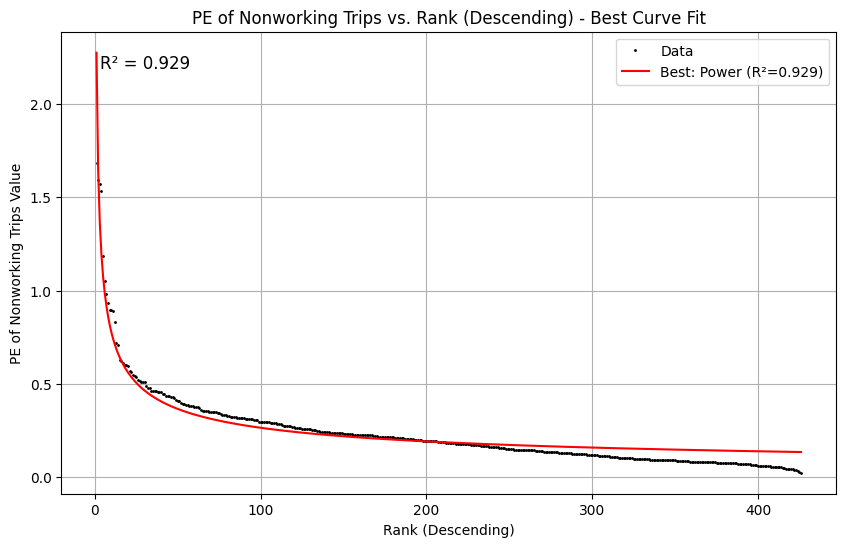

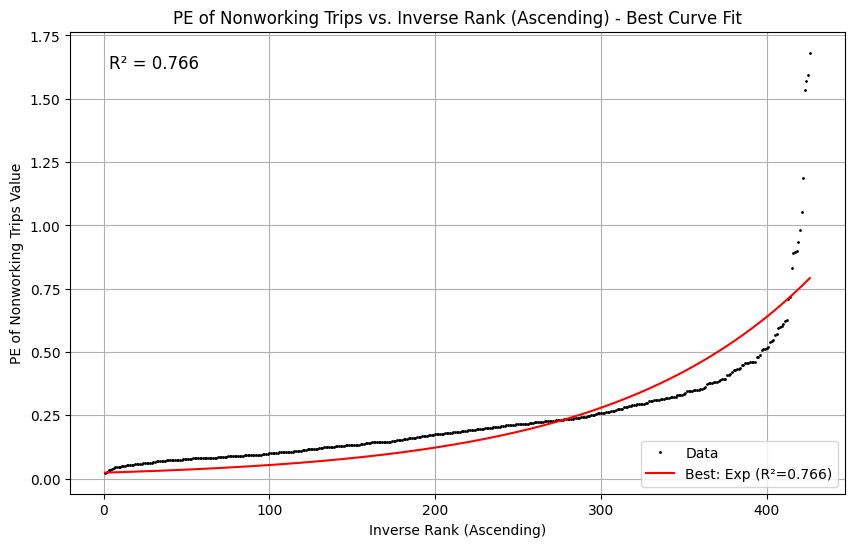

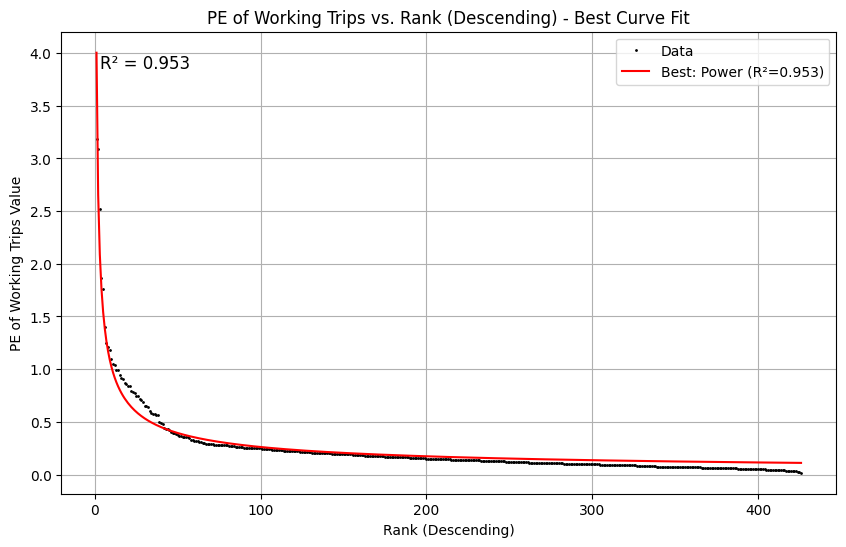

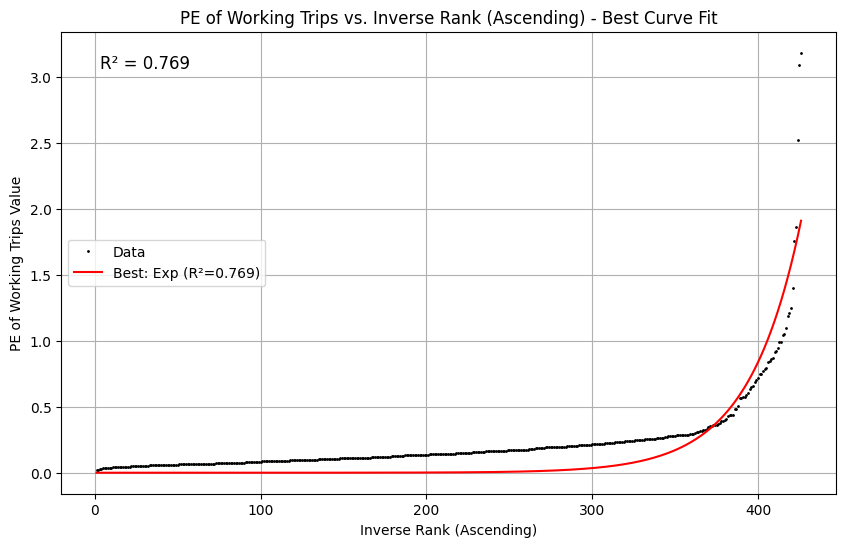

<ipython-input-3-3057416621>:19: RuntimeWarning: overflow encountered in power
  return a * (x ** b)
<ipython-input-3-3057416621>:19: RuntimeWarning: overflow encountered in multiply
  return a * (x ** b)


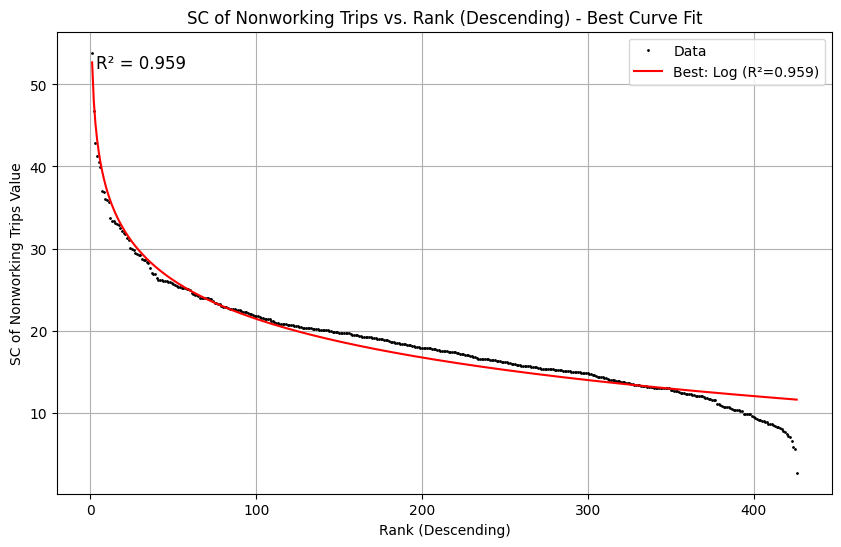

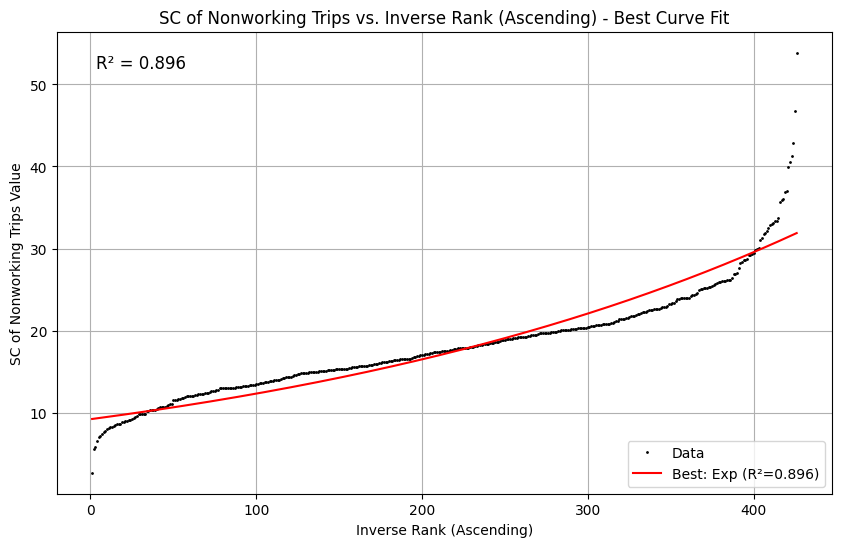

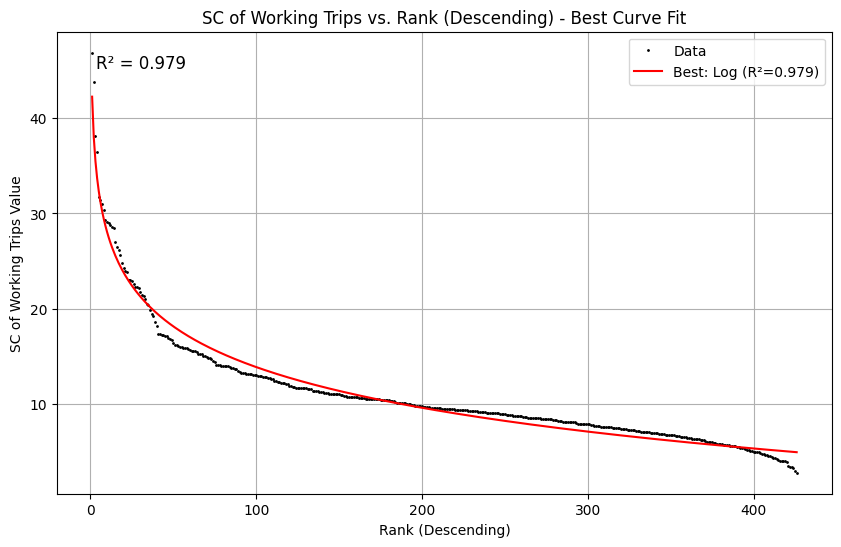

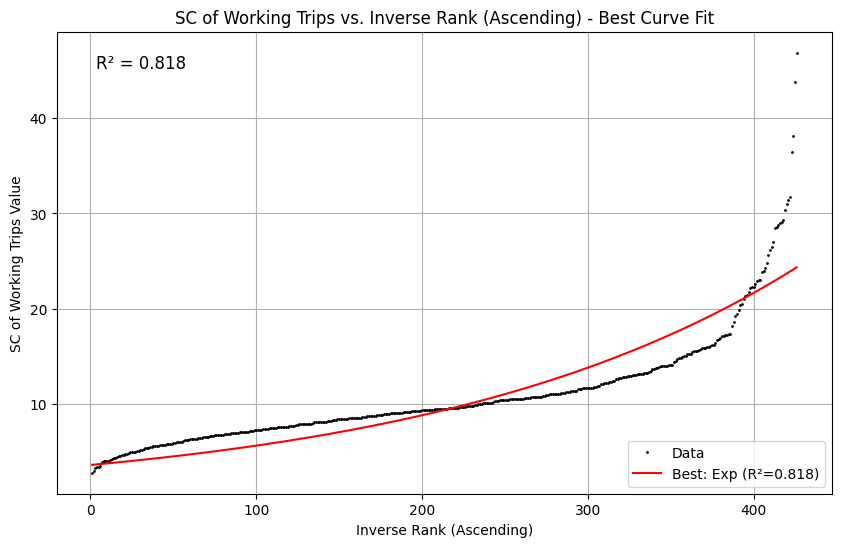

Results saved to /content/drive/MyDrive/FMC_Data/CurveFitting/curve_fit_results.xlsx


In [19]:
indices = ['PE3_Seoul', 'PE7_Seoul', 'SC1', 'SC2']
pretty_names = {
    'PE3_Seoul': 'PE of Nonworking Trips',
    'PE7_Seoul': 'PE of Working Trips',
    'SC1': 'SC of Nonworking Trips',
    'SC2': 'SC of Working Trips'
}

xlabels = {
    'Rank': 'Rank (Descending)',
    'InvRank': 'Inverse Rank (Ascending)'
}

# Results table
all_results = []

for index_name in indices:
    data = df[index_name].dropna()
    sorted_values = data.sort_values(ascending=False).reset_index(drop=True)
    n = len(sorted_values)
    rank = np.arange(1, n + 1)
    inverse_rank = n - rank + 1

    for rank_type, x in [('Rank', rank), ('InvRank', inverse_rank)]:
        fit_results = fit_and_compare(x, sorted_values.values)
        if fit_results:
            # For each model, append result row
            for res in fit_results:
                row = {
                    'Index': index_name,
                    'RankType': rank_type,
                    'Model': res['Model'],
                    'R2': res['R2'],
                    'RMSE': res['RMSE'],
                    'AIC': res['AIC'],
                    'BIC': res['BIC'],
                    'n': res['n'],
                    'k': res['k'],
                    'rss': res['rss']
                }
                # Add parameters
                for i in range(res['k']):
                    row[f'param_{i+1}'] = res.get(f'param_{i+1}', np.nan)
                all_results.append(row)
            # Plot best fit
            plot_title = f"{pretty_names[index_name]} vs. {xlabels[rank_type]} - Best Curve Fit"
            x_axis_title = xlabels[rank_type]
            plot_best_fit(
                x, sorted_values.values, fit_results,
                index_name=pretty_names[index_name],
                rank_type=x_axis_title,
                plot_title=plot_title,
                save_dir=save_dir
            )


# Save to Excel
results_df = pd.DataFrame(all_results)
excel_path = os.path.join(save_dir, "curve_fit_results.xlsx")
results_df.to_excel(excel_path, index=False)
print(f"Results saved to {excel_path}")